In [1]:
import nbimporter
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch import nn
from torch.optim import SGD
from sklearn.metrics import accuracy_score
from os.path import join
import torch
import numpy as np
from PIL import Image
from os import path

import python_file.dataclass as StreetSign
import python_file.function as Function
import python_file.network as Network

import matplotlib.pyplot as plt

from python_file.dirPath import csvDir, imageDir, dayTest

np.random.seed(1328)
torch.random.manual_seed(1328)

#number of epoch
epoche = 200

In [2]:
#resize normale
tran = transforms.Compose([StreetSign.Rescale(32),StreetSign.RandomCrop(32),StreetSign.ToTensor()])

In [3]:
datatrain = StreetSign.StreetSignDataset(csvDir / 'classes.csv',imageDir,tran)
datatest = StreetSign.StreetSignTest( dayTest / 'prova.txt',dayTest,tran)

In [4]:
datatrain_loader = DataLoader(datatrain, batch_size=1024, shuffle=True)
datatest_loader = DataLoader(datatest, batch_size=1024, shuffle=True)

In [5]:
minialexnetV2_datatrain = Network.MiniAlexNetV2()

minialexnetV2_datatrain = Function.train_classifier(minialexnetV2_datatrain, datatrain_loader, datatest_loader, \
                                                    'minialexnetV2_dataset', epochs = epoche)

minialexnetV2_data_test_predictions, data_labels_test = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatest_loader)
print("Accuracy MiniAlexNetV2 su StreetSign: %0.2f" % \
      accuracy_score(data_labels_test,minialexnetV2_data_test_predictions))

Accuracy MiniAlexNetV2 su StreetSign: 0.85


In [6]:
data_labels_test

array([2, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0,
       1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0,
       2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1,
       0, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2,
       1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0,
       1, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 1, 2, 0, 2, 2, 2, 1, 0, 0, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1,

In [7]:
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    # calcoliamo tutti gli errori mediante MAE
    errors = np.abs(np.array((predictions-gt)))
    
    # prendiamo i valori unici degli errori e ordiniamoli
    tolerances = sorted(np.unique(errors))
    correct= [] #lista delle "accuracy" relative a ogni soglia
    
    for t in tolerances:
        correct.append((errors<=t).mean()) # frazione di elementi "correttamente" regressi
    AUC = np.trapezoid(correct, tolerances) #area sotto la curva calcolata col metodo dei trapezi
    tot_area = np.max(tolerances)*1 # area totale
    AOC = tot_area - AUC
    # restituiamo le soglie, la frazione di campioni correttamente regressi e l'area sopra la curva
    return tolerances, correct, AOC

In [8]:
minialexnetV2_data_test_predictions, data_labels_test = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatest_loader)

minialexnetV2_data_train_predictions, data_labels_train = Function.test_classifier(minialexnetV2_datatrain,
                                                                               datatrain_loader)

[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
[np.float64(0.8454545454545455), np.float64(0.9393939393939394), np.float64(0.9757575757575757), np.float64(1.0)]
0.1621212121212121


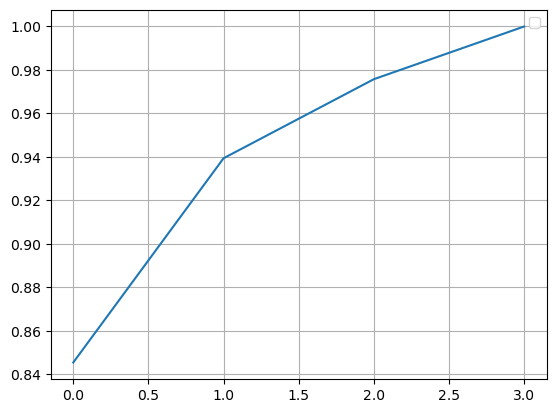

In [9]:
# REC curve:
alexnet_rec_test = rec_curve(minialexnetV2_data_test_predictions, data_labels_test)
alexnet_rec_train = rec_curve(minialexnetV2_data_train_predictions, data_labels_train)
print(alexnet_rec_test[0])
print(alexnet_rec_test[1])
print(alexnet_rec_test[2])
plt.plot(alexnet_rec_test[0], alexnet_rec_test[1])
plt.plot(alexnet_rec_train[0], alexnet_rec_train[1])
plt.legend(['AlexNetTest. AOC: %.2f'%alexnet_rec_test[2]],['AlexNetTrain. AOC: %.2f'%alexnet_rec_train[2]])
plt.grid()
plt.show()

In [10]:
minialexnet_datatrain = Network.MiniAlexNet()

minialexnet_datatrain = Function.train_classifier(minialexnet_datatrain, datatrain_loader, datatest_loader, \
                                                    'minialexnet_dataset', epochs = epoche)

minialexnet_data_test_predictions, data_labels_test = Function.test_classifier(minialexnet_datatrain,
                                                                               datatest_loader)
print("Accuracy MiniAlexNet su StreetSign: %0.2f" % \
      accuracy_score(data_labels_test,minialexnet_data_test_predictions))

Accuracy MiniAlexNet su StreetSign: 0.58


In [11]:
lenet_datatrain = Network.LeNetColor()

lenet_datatrain = Function.train_classifier(lenet_datatrain, datatrain_loader, datatest_loader, \
                                                    'lenet_dataset', epochs = epoche)

lenet_data_test_predictions, data_labels_test = Function.test_classifier(lenet_datatrain,
                                                                               datatest_loader)
print("Accuracy LeNet su StreetSign: %0.2f" % \
      accuracy_score(data_labels_test,lenet_data_test_predictions))

Accuracy LeNet su StreetSign: 0.81


In [12]:
inialexnet_data_test_predictions, data_labels_test = Function.test_classifier(minialexnet_datatrain,
                                                                               datatest_loader)

minialexnet_data_train_predictions, data_labels_train = Function.test_classifier(minialexnet_datatrain,
                                                                               datatrain_loader)

lenet_data_test_predictions, data_labels_test = Function.test_classifier(lenet_datatrain,
                                                                               datatest_loader)

lenet_data_train_predictions, data_labels_train = Function.test_classifier(lenet_datatrain,
                                                                               datatrain_loader)

[np.int64(0), np.int64(1)]
[np.float64(0.5818181818181818), np.float64(1.0)]
0.2090909090909091


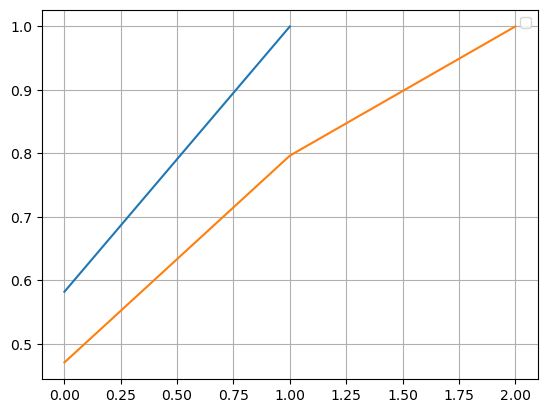

In [13]:
# REC curve:
alexnet_rec_test = rec_curve(minialexnet_data_test_predictions, data_labels_test)
alexnet_rec_train = rec_curve(minialexnet_data_train_predictions, data_labels_train)
print(alexnet_rec_test[0])
print(alexnet_rec_test[1])
print(alexnet_rec_test[2])
plt.plot(alexnet_rec_test[0], alexnet_rec_test[1])
plt.plot(alexnet_rec_train[0], alexnet_rec_train[1])
plt.legend(['AlexNetTest. AOC: %.2f'%alexnet_rec_test[2]],['AlexNetTrain. AOC: %.2f'%alexnet_rec_train[2]])
plt.grid()
plt.show()

[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
[np.float64(0.806060606060606), np.float64(0.9), np.float64(0.9575757575757575), np.float64(1.0)]
0.23939393939393927


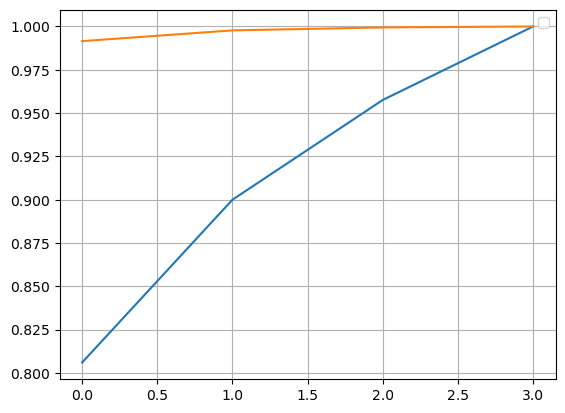

In [14]:
# REC curve:
alexnet_rec_test = rec_curve(lenet_data_test_predictions, data_labels_test)
alexnet_rec_train = rec_curve(lenet_data_train_predictions, data_labels_train)
print(alexnet_rec_test[0])
print(alexnet_rec_test[1])
print(alexnet_rec_test[2])
plt.plot(alexnet_rec_test[0], alexnet_rec_test[1])
plt.plot(alexnet_rec_train[0], alexnet_rec_train[1])
plt.legend(['AlexNetTest. AOC: %.2f'%alexnet_rec_test[2]],['AlexNetTrain. AOC: %.2f'%alexnet_rec_train[2]])
plt.grid()
plt.show()